# 1. Import necessary packages

In [4]:
import numpy as np
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import datetime
import os



# 2. Load image files, then split into train-validation set

In [5]:
file_path= r"G:\My Drive\Colab Notebooks\Project\Concrete Crack Images for Classification"
data_dir=pathlib.Path(file_path)
SEED = 12345
IMG_SIZE = (160,160)
BATCH_SIZE = 16
train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,validation_split=0.3,subset='training',seed=SEED,shuffle=True,image_size=IMG_SIZE,batch_size=BATCH_SIZE)
val_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,validation_split=0.3,subset='validation',seed=SEED,shuffle=True,image_size=IMG_SIZE,batch_size=BATCH_SIZE)

Found 40000 files belonging to 2 classes.
Using 28000 files for training.
Found 40000 files belonging to 2 classes.
Using 12000 files for validation.


# 3. Further split validation set, so that we obtain validation and test data

In [6]:
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches//5)
validation_dataset = val_dataset.skip(val_batches//5)

## 3.1 Create prefetch dataset


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset_pf = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset_pf = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset_pf = test_dataset.prefetch(buffer_size=AUTOTUNE)

# 4. Create model by applying transfer learning, we are using MobileNetV2 for this project.

## 4.1. Define a layer that preprocess inputs for the transfer learning model

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## 4.2 Create base model with MobileNetV2

In [9]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

## 4.3 Freeze the base model and view the model structure

In [10]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

## 4.4 Create classification layers with global average pooling and dense layer

In [11]:
class_names = train_dataset.class_names
global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()
output_dense = tf.keras.layers.Dense(len(class_names),activation='softmax')

## 4.5. Use functional API to build the entire model

In [12]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x)
x = global_avg_pool(x)
outputs = output_dense(x)

### print out the model

In [13]:
model = tf.keras.Model(inputs,outputs)
#Print out the model structure
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_______________________________________________

## 4.6. Compile model

In [14]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=adam,loss=loss,metrics=['accuracy'])

# 5. Perform training

In [15]:
EPOCHS = 10
base_log_path = r"G:\My Drive\Colab Notebooks\Project\Log\LogConcrete"
log_path = os.path.join(base_log_path, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
history = model.fit(train_dataset_pf,validation_data=validation_dataset_pf,epochs=EPOCHS)

Epoch 1/10
1750/1750 [==============================] - 56s 30ms/step - loss: 0.0528 - accuracy: 0.9831 - val_loss: 0.0103 - val_accuracy: 0.9972
Epoch 2/10
1750/1750 [==============================] - 48s 27ms/step - loss: 0.0083 - accuracy: 0.9977 - val_loss: 0.0066 - val_accuracy: 0.9982
Epoch 3/10
1750/1750 [==============================] - 48s 28ms/step - loss: 0.0058 - accuracy: 0.9983 - val_loss: 0.0057 - val_accuracy: 0.9985
Epoch 4/10
1750/1750 [==============================] - 47s 27ms/step - loss: 0.0045 - accuracy: 0.9988 - val_loss: 0.0052 - val_accuracy: 0.9986
Epoch 5/10
1750/1750 [==============================] - 47s 27ms/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 0.0048 - val_accuracy: 0.9987
Epoch 6/10
1750/1750 [==============================] - 48s 27ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.0047 - val_accuracy: 0.9987
Epoch 7/10
1750/1750 [==============================] - 49s 28ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0045 -

# 6. Evaluate with test dataset

In [16]:
test_loss,test_accuracy = model.evaluate(test_dataset_pf)

print('------------------------Test Result----------------------------')
print(f'Loss = {test_loss}')
print(f'Accuracy = {test_accuracy}')


150/150 [==============================] - 3s 19ms/step - loss: 0.0023 - accuracy: 0.9992
------------------------Test Result----------------------------
Loss = 0.0023269308730959892
Accuracy = 0.9991666674613953



# 7. Deploy model to make prediction

In [17]:
image_batch, label_batch = test_dataset_pf.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
class_predictions = np.argmax(predictions,axis=1)

# 8. Show some prediction results

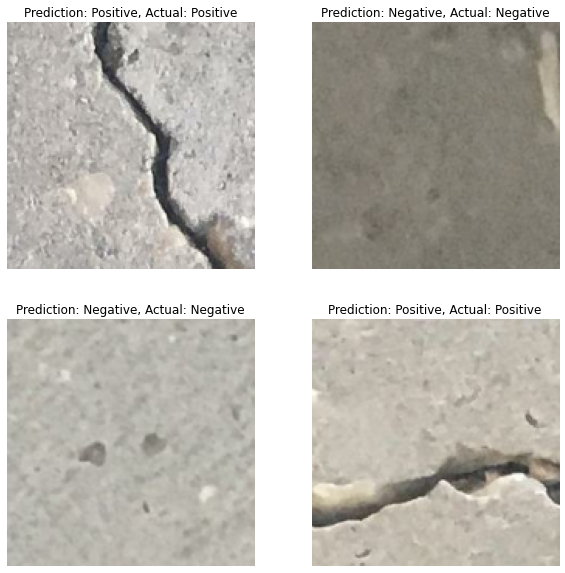

In [18]:
plt.figure(figsize=(10,10))

for i in range(4):
    axs = plt.subplot(2,2,i+1)
    plt.imshow(image_batch[i].astype('uint8'))
    current_prediction = class_names[class_predictions[i]]
    current_label = class_names[label_batch[i]]
    plt.title(f"Prediction: {current_prediction}, Actual: {current_label}")
    plt.axis('off')
    
save_path = r"G:\My Drive\Colab Notebooks\Project\Log\Results"
plt.savefig(os.path.join(save_path,"cnn_concreteclassification.png"),bbox_inches='tight')
plt.show()